# Make daily mean figures for animations of the major rates, tracers of the ROMS-BEC

## import packages

In [1]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib as mpl
import seaborn as sb
sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# others
import scipy as sc
from scipy.interpolate import interp1d

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("netCDF4 version =", nc.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sc.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg"
os.chdir(wrkdir)
os.getcwd()

#ProgressBar().register()


python version = 3.10.
numpy version = 1.26.4
xarray version = 2024.3.0
netCDF4 version = 1.6.5
dask version = 2023.3.0
pandas version = 2.2.3
scipy version = 1.14.1
seaborn version = 0.12.2
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


'/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg'

## load model daily data

In [2]:
data = xr.open_mfdataset(['2hets_def/avg_2050_D000-D090.nc','2hets_def/avg_2050_D091-D180.nc','2hets_def/avg_2050_D181-D270.nc', '2hets_def/avg_2050_D271-D365.nc'])
norm_hz = data["Hz"]
norm_zr = data["z_r"]
norm_o2 = data["O2"]
norm_no2 = data["NO2"]
norm_ammox = data["AMMOX"]
norm_nitrox = data["NITROX"]
norm_no3red = data["DENITRIF1"]
norm_no2red = data["DENITRIF5"]
norm_anammox = data["ANAMMOX"]
norm_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
norm_aoa = data["AOA"].where(data["AOA"] > 0.0, other=0.0)
norm_o2cons = data["O2_CONSUMPTION"]



/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero e

## Get coordinates

In [3]:
fname = '/home/pbuchanan/peru_chile_0p1_files/peru_chile_0p1_grd.nc' 
data = xr.open_dataset(fname)
data = data.rename_dims({"eta_rho":"y_c", "xi_rho":"x_c"})
lon_rho = data.coords['lon_rho']
lat_rho = data.coords['lat_rho']

pn = data['pm']
pm = data['pn']
area = 1.0/(pn*pm)


## define new dataset with chunks

In [4]:

chunky = {'time':1, 'z_c':1, 'y_c':502, 'x_c':402}
ds = xr.Dataset(
    {"lon_rho": ( ("y_c", "x_c"), lon_rho.values),
     "lat_rho": ( ("y_c", "x_c"), lat_rho.values),
     "area":    ( ("y_c", "x_c"), area.values),
     "norm_Hz": ( ("time", "z_c", "y_c", "x_c"), norm_hz.values),
     },
    coords={"x_c": (["x_c"], np.arange(1,403)),
            "y_c": (["y_c"], np.arange(1,503)),
            "z_c": (["z_c"], np.arange(1,43)),
            "time":(["time"],np.arange(1,366))}).chunk(chunks=chunky)

# check size of the arrays in Gb and their chunks in Mb
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)


Total size of array in Gb 12.377053416
Total size of chunk in Mb 36.332296


/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_34055880/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid val

## append the variables into the new dataset

In [5]:
### assign other variables to the dataset
ds = ds.assign({"norm_zr": ( ("time", "z_c", "y_c", "x_c"), norm_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"norm_O2": ( ("time", "z_c", "y_c", "x_c"),  norm_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"norm_NO2": ( ("time", "z_c", "y_c", "x_c"),  norm_no2.values)}).chunk(chunks=chunky)
print("Added NO2")
ds = ds.assign({"norm_ammox": ( ("time", "z_c", "y_c", "x_c"), norm_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"norm_nitrox": ( ("time", "z_c", "y_c", "x_c"), norm_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"norm_NO3red": ( ("time", "z_c", "y_c", "x_c"), norm_no3red.values)}).chunk(chunks=chunky)
print("Added NO3red")
ds = ds.assign({"norm_NO2red": ( ("time", "z_c", "y_c", "x_c"), norm_no2red.values)}).chunk(chunks=chunky)
print("Added NO2red")
ds = ds.assign({"norm_anammox": ( ("time", "z_c", "y_c", "x_c"), norm_anammox.values)}).chunk(chunks=chunky)
print("Added anammox")
ds = ds.assign({"norm_NOB": ( ("time", "z_c", "y_c", "x_c"), norm_nob.values)}).chunk(chunks=chunky)
print("Added NOB")
ds = ds.assign({"norm_AOA": ( ("time", "z_c", "y_c", "x_c"), norm_aoa.values)}).chunk(chunks=chunky)
print("Added AOA")
ds = ds.assign({"norm_o2cons": ( ("time", "z_c", "y_c", "x_c"), norm_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")


ds

Added z_rho
Added O2
Added NO2
Added ammox
Added nitrox
Added NO3red
Added NO2red
Added anammox
Added NOB
Added AOA
Added o2cons


<xarray.Dataset> Size: 148GB
Dimensions:       (y_c: 502, x_c: 402, time: 365, z_c: 42)
Coordinates:
  * x_c           (x_c) int64 3kB 1 2 3 4 5 6 7 ... 396 397 398 399 400 401 402
  * y_c           (y_c) int64 4kB 1 2 3 4 5 6 7 ... 496 497 498 499 500 501 502
  * z_c           (z_c) int64 336B 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42
  * time          (time) int64 3kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables: (12/15)
    lon_rho       (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    lat_rho       (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    area          (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    norm_Hz       (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_zr       (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_O2       (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    ...            ...
    norm_NO3red   (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_NO2red   (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_anammox  (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_NOB      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_AOA      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_o2cons   (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>

## check size of the dataset

In [6]:
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)


Total size of array in Gb 148.497887496
Total size of chunk in Mb 409.26608799999997


## compute the means with 200-400 metres and along 85ºW

In [7]:
### select data between certain depths
dep1 = 200.
dep2 = 400.
### grab the coordinate variables for plotting
slice_y = ds['lat_rho'].isel(x_c=slice(1,399)).values
slice_x = ds['lon_rho'].isel(x_c=slice(1,399)).values
### calculate the variables of interest!
slice_o2 = ds["norm_O2"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).mean(dim="z_c")
slice_no2 = ds["norm_NO2"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).mean(dim="z_c")
slice_nhx = ds["norm_ammox"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).max(dim="z_c")
slice_nox = ds["norm_nitrox"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).max(dim="z_c")
slice_no3red = ds["norm_NO3red"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).max(dim="z_c")
slice_no2red = ds["norm_NO2red"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).max(dim="z_c")
slice_anammox = ds["norm_anammox"].where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).max(dim="z_c")
slice_nob2aoa = (ds["norm_NOB"]/ds["norm_AOA"]).where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).mean(dim="z_c")
slice_o2nob = (ds["norm_nitrox"] * 12.9/27.8 / ds["norm_o2cons"]*100.0).where((-ds["norm_zr"] > dep1).compute() & (-ds["norm_zr"] < dep2).compute(), drop=True).max(dim="z_c")


### define the longitude of interest where we conduct the transect
longitude=275
lon1 = longitude-0.5
lon2 = longitude+0.5
### grab the coordinate variables for plotting
transect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_z = ds["norm_zr"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
### calculate the variables of interest!
transect_o2 = ds["norm_O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_no2 = ds["norm_NO2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_nhx = ds["norm_ammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
transect_nox = ds["norm_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
transect_no3red = ds["norm_NO3red"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
transect_no2red = ds["norm_NO2red"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
transect_anammox = ds["norm_anammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
transect_nob2aoa = (ds["norm_NOB"]/ds["norm_AOA"]).where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_o2nob = (ds["norm_nitrox"] * 12.9/27.8 / ds["norm_o2cons"]*100.0).where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")


slice_o2 = slice_o2.where(slice_o2 > 0.0, other=0.0)
slice_no2 = slice_no2.where(slice_no2 > 0.0, other=0.0)

transect_o2 = transect_o2.where(transect_o2 > 0.0, other=0.0)
transect_no2 = transect_no2.where(transect_no2 > 0.0, other=0.0)


## make the transect latitude axis coordinate compatible with the 2D depth coordinate

In [8]:
transect_y_2d = transect_y.expand_dims(z_c=np.arange(42)).copy()
transect_y_2d = transect_y_2d.assign_coords({"z_c": transect_z.coords['z_c'].values})


## make 365 figures of O2 variations

In [9]:

contcol = 'k' 

colmap1 = lighten(cmo.oxy, 0.8)
levs1 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [1, 10, 20, 50]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


In [10]:

for ii in np.arange(365):
    savename = 'oxy_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_o2.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 1, 5, 10, 50, 100])
    cb1.ax.set_xlabel('Oxygen ($\mu$M)', fontsize=fslab)
    #cb1.ax.set_xlabel('Nitrite Oxidation (nM day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_oxy/" + savename, dpi=300, transparent=True)
    plt.close(fig)


## make 365 figures of NO2 variations

In [11]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,1)*0.1, np.arange(1,5.1,0.25)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [0.5, 1, 2.5, 5]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


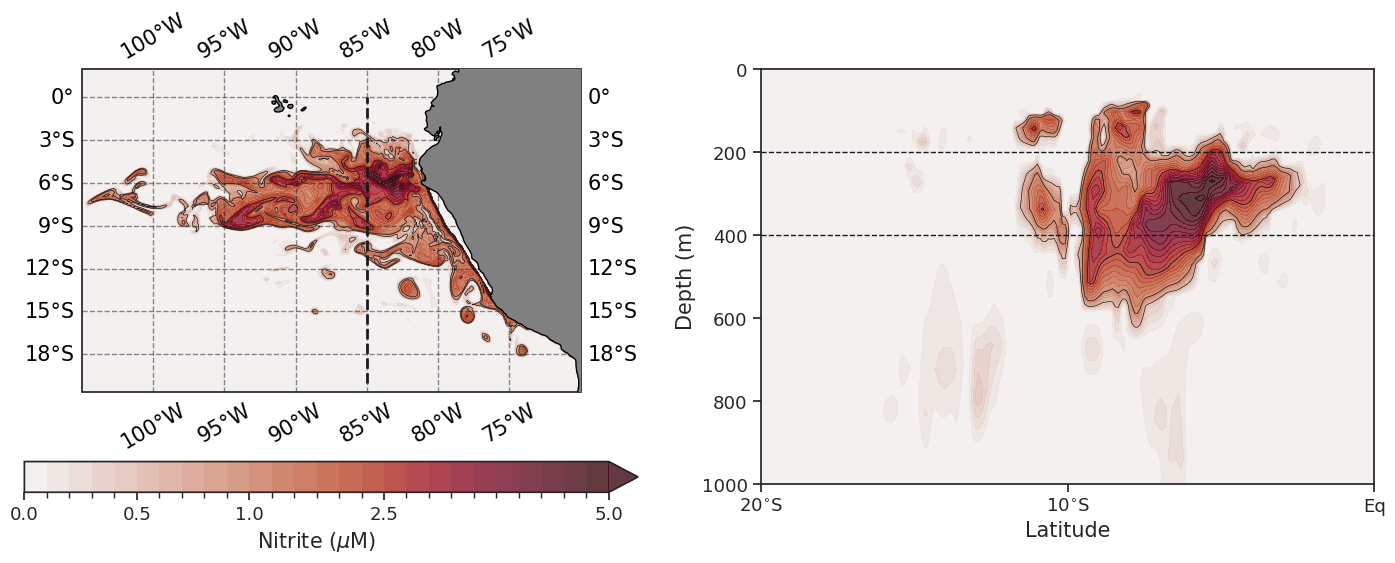

In [12]:

for ii in np.arange(365):
    savename = 'no2_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_no2.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    c1 = ax1.contour(slice_x, slice_y, slice_no2.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_no2.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_no2.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 0.5, 1, 2.5, 5])
    cb1.ax.set_xlabel('Nitrite ($\mu$M)', fontsize=fslab)
    #cb1.ax.set_xlabel('Nitrite Oxidation (nM day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_no2/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of ammonia oxidation variations

In [13]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,1), np.arange(10,101,5)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [5, 10, 50, 100]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


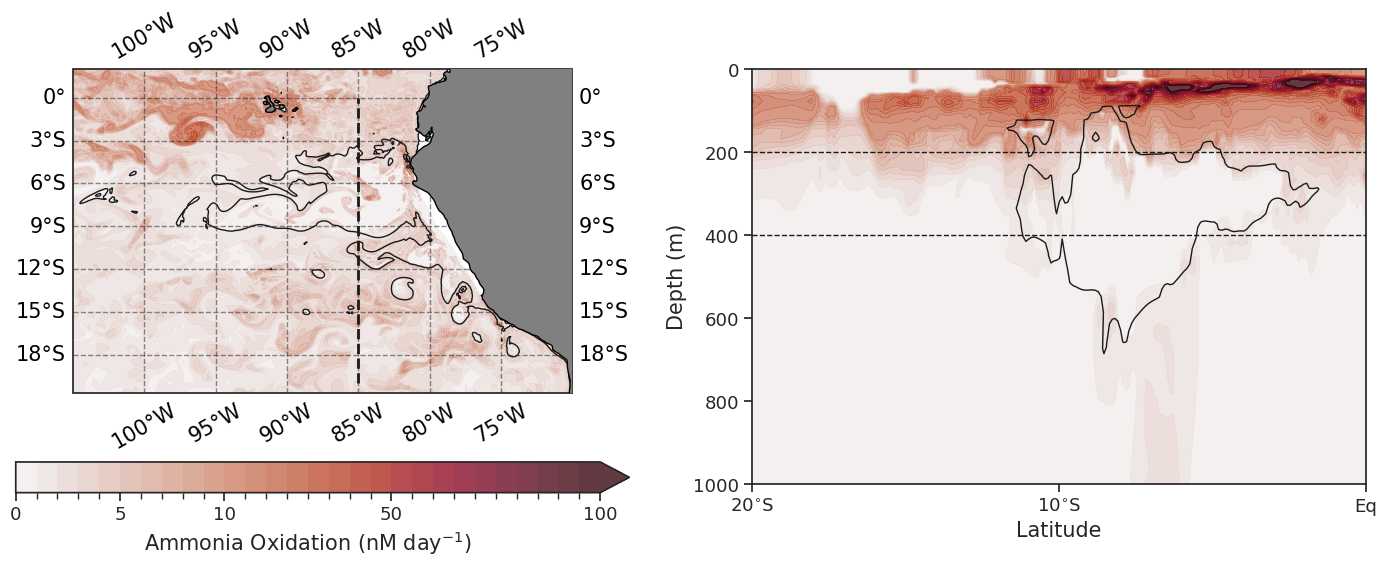

In [14]:

for ii in np.arange(365):
    savename = 'nhx_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_nhx.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_nhx.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_nhx.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_nhx.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 5, 10, 50, 100])
    cb1.ax.set_xlabel('Ammonia Oxidation (nM day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_nhx/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of nitrite oxidation variations

In [15]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,1), np.arange(10,100,10), np.arange(100,301,20)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [5, 10, 50, 100, 200]
contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


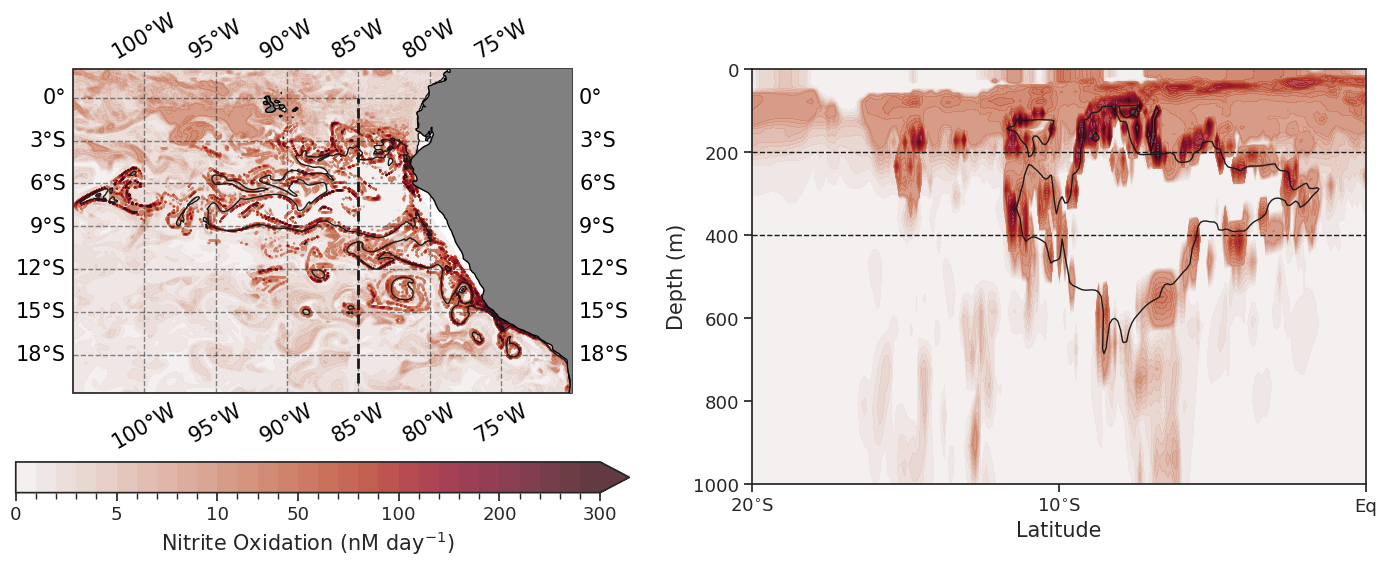

In [16]:

for ii in np.arange(365):
    savename = 'nox_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_nox.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_nox.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_nox.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_nox.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 5, 10, 50, 100, 200, 300])
    cb1.ax.set_xlabel('Nitrite Oxidation (nM day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_nox/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of nitrate reduction variations

In [17]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,1), np.arange(10,100,10), np.arange(100,301,20)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [5, 10, 50, 100, 200]
contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


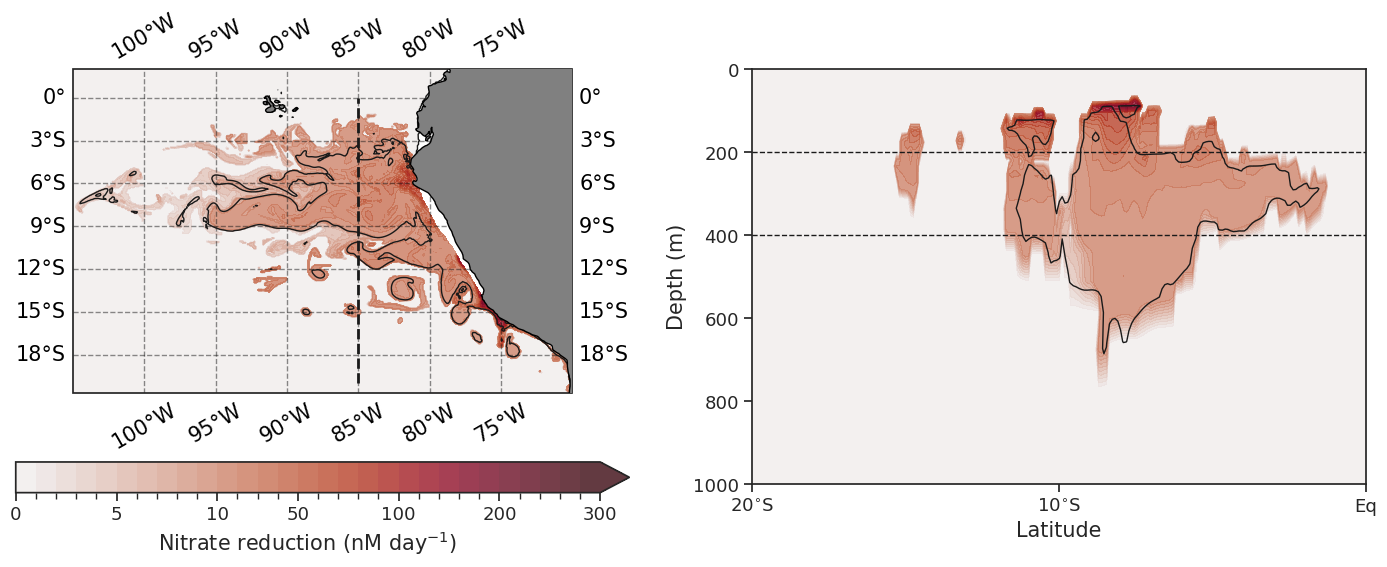

In [18]:

for ii in np.arange(365):
    savename = 'no3red_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_no3red.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_no3red.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_no3red.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_no3red.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 5, 10, 50, 100, 200, 300])
    cb1.ax.set_xlabel('Nitrate reduction (nM day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_no3red/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of nitrite reduction variations

In [19]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,1), np.arange(10,101,5)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [5, 10, 50, 100]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


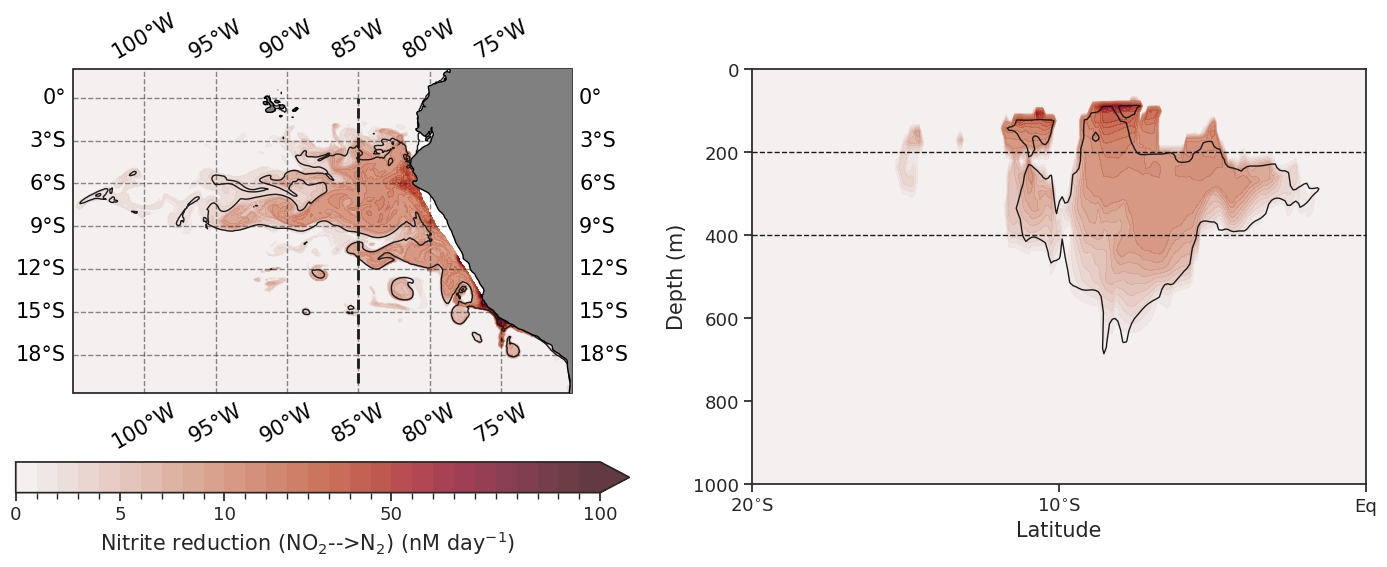

In [20]:

for ii in np.arange(365):
    savename = 'no2red_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_no2red.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_no2red.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_no2red.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_no2red.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 5, 10, 50, 100])
    cb1.ax.set_xlabel('Nitrite reduction (NO$_2$-->N$_2$) (nM day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_no2red/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of anammox variations

In [21]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,1), np.arange(10,51,2.5)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [5, 10, 25, 50]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


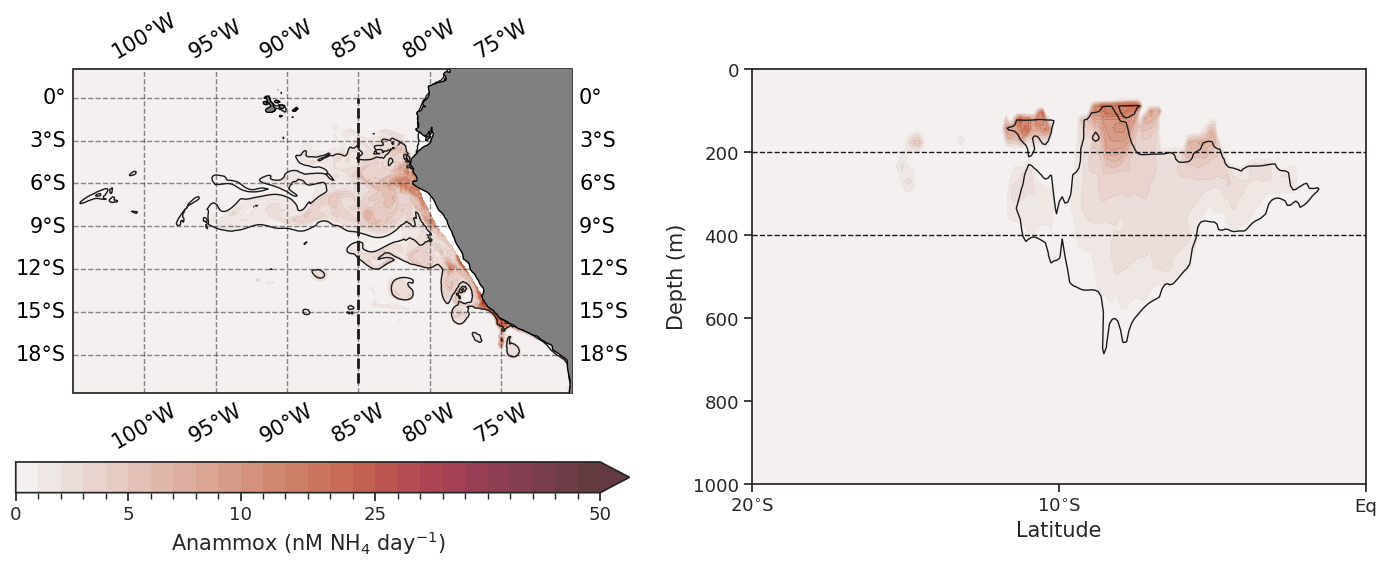

In [22]:

for ii in np.arange(365):
    savename = 'anammox_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_anammox.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_anammox.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_anammox.isel(time=ii)*86400*1e3, vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_anammox.isel(time=ii)*86400*1e3, levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 5, 10, 25, 50])
    cb1.ax.set_xlabel('Anammox (nM NH$_4$ day$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_anammox/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of NOB:AOA variations

In [23]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.arange(0.0,2.1,0.1)
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [0.1, 0.5, 1.0, 2.0]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


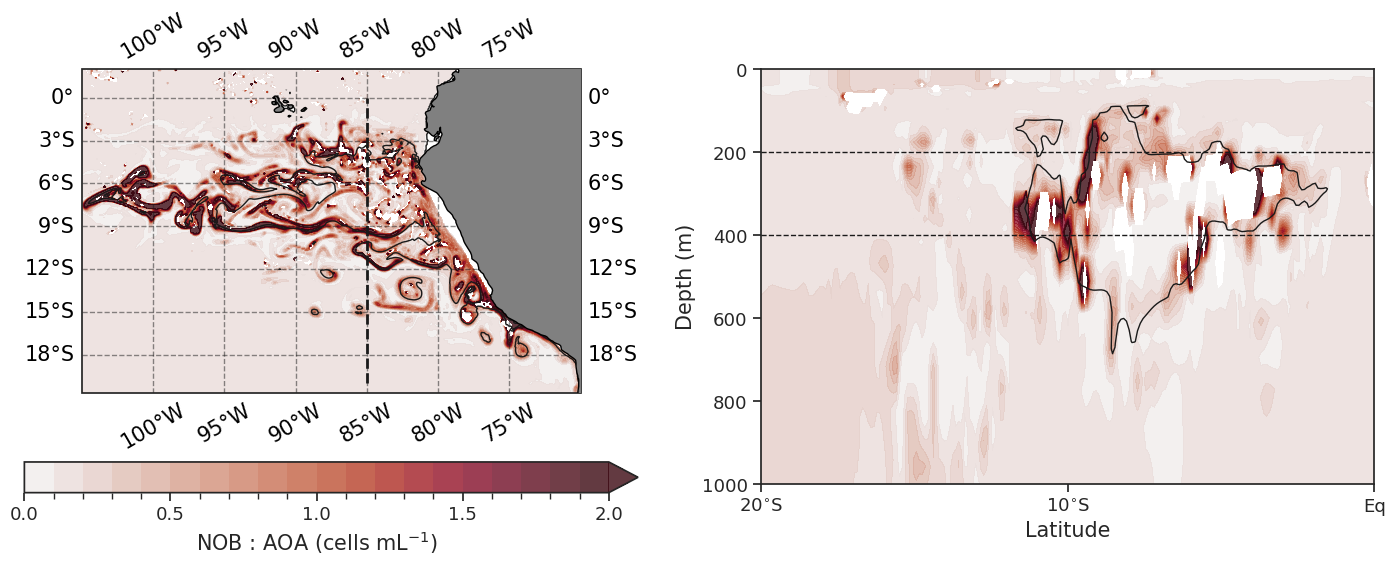

In [24]:

Ccell_nob = 3.98e-15 
Ccell_aoa = 1.15e-15
cells_per_mL_nob = 1e-3 * 12 / Ccell_nob * 1e-6
cells_per_mL_aoa = 1e-3 * 12 / Ccell_aoa * 1e-6

slice_nob2aoa = slice_nob2aoa * cells_per_mL_nob / cells_per_mL_aoa
transect_nob2aoa = transect_nob2aoa * cells_per_mL_nob / cells_per_mL_aoa



for ii in np.arange(365):
    savename = 'nob2aoa_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_nob2aoa.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_nob2aoa.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_nob2aoa.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_nob2aoa.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 0.5, 1, 1.5, 2.0])
    cb1.ax.set_xlabel('NOB : AOA (cells mL$^{-1}$)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_nob2aoa/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)


## make 365 figures of NOB contribution to O2 consumption variations

In [25]:

contcol = 'k' 

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate(( np.arange(0,10,1), np.arange(10,101,5) )) 
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [5, 10, 25, 50]
contl1 = [0.5, 0.5, 0.5, 0.5]

fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


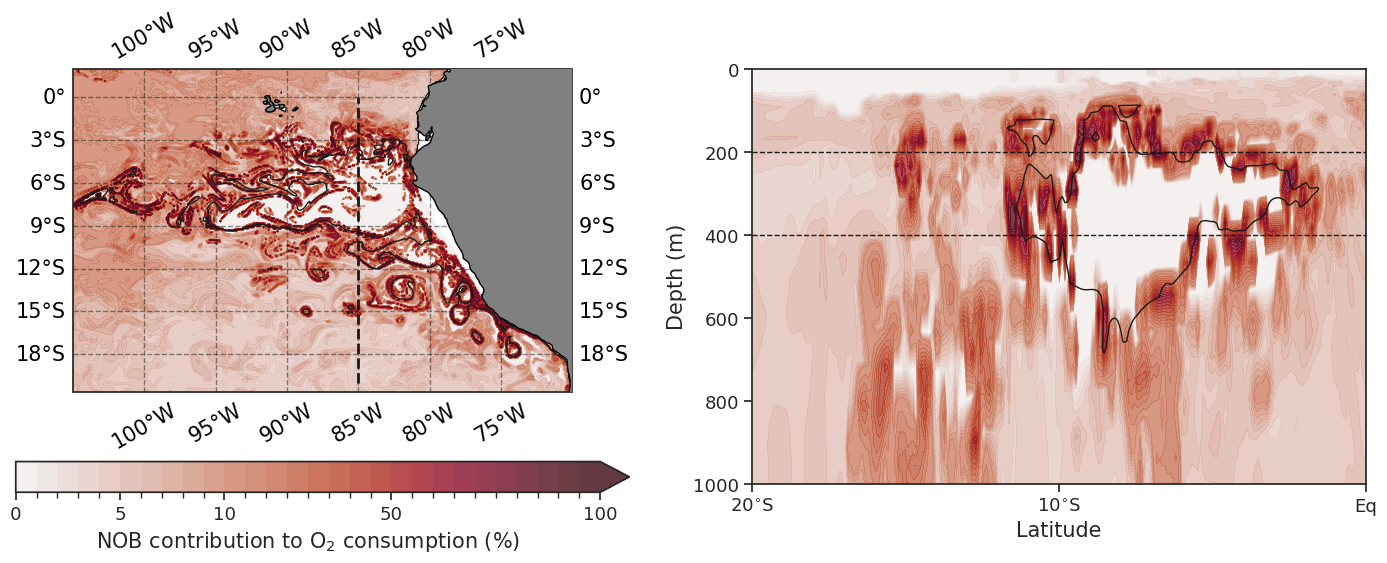

In [26]:

for ii in np.arange(365):
    savename = 'o2nob_{0:03d}.png'.format(ii)
    
    fig = plt.figure(facecolor='w', figsize=(15,6))
    gs = GridSpec(10,2)
    
    ax1 = plt.subplot(gs[:,0], projection=proj)
    ax1.set_extent([-105,-70,-20,2])
    ax2 = plt.subplot(gs[0:9,1])
    
    
    p1 = ax1.contourf(slice_x, slice_y, slice_o2nob.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
    #c1 = ax1.contour(slice_x, slice_y, slice_o2nob.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
    ax1.plot((longitude,longitude),(-20,0), 'k--', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
    
    p2 = ax2.contourf(transect_y_2d, -transect_z.isel(time=ii), transect_o2nob.isel(time=ii), vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
    #c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2nob.isel(time=ii), levels=conts1, colors=contcol, linewidths=contl1)
    ax2.plot((-20,0),(dep1,dep1), 'k--', linewidth=1, zorder=3)
    ax2.plot((-20,0),(dep2,dep2), 'k--', linewidth=1, zorder=3)

    c1 = ax1.contour(slice_x, slice_y, slice_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0, transform=ccrs.PlateCarree())
    c2 = ax2.contour(transect_y_2d, -transect_z.isel(time=ii), transect_o2.isel(time=ii), levels=[1.0], colors=contcol, linewidths=1.0)
    
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black', 'rotation':30}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
    ax1.coastlines(zorder=3)
    
    cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=[0, 5, 10, 50, 100])
    cb1.ax.set_xlabel('NOB contribution to O$_2$ consumption (%)', fontsize=fslab)
    cb1.ax.tick_params(labelsize=fstic)
    
    x1 = -20; x2 = 0
    y1 = 1000; y2 = 0
    ax2.set_xlim(x1,x2)
    ax2.set_ylim(y1,y2)
    ax2.tick_params(labelsize=fstic)
    ax2.set_ylabel("Depth (m)", fontsize=fslab)
    ax2.set_xlabel("Latitude", fontsize=fslab)
    ax2.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
    
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.2)
        
    fig.savefig("/home/pbuchanan/analysis_nox/figures/anim_o2nob/" + savename, dpi=300, transparent=True)
    if ii > 0:
        plt.close(fig)
